# Advanced lane tracking pipeline

In [1]:
#All the required imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#To disable warnings in matplotlib
plt.rcParams.update({'figure.max_open_warning': 0})

global flag, left_fit, right_fit
flag = True
global avg_list
avg_list = []
print(flag)

True


## Camera calibration

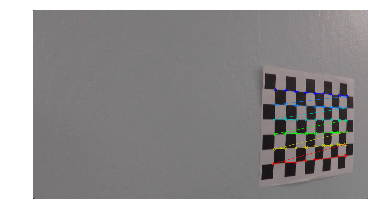

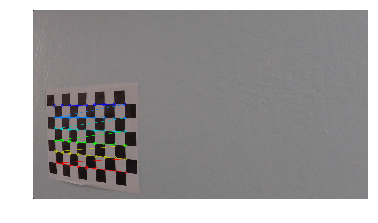

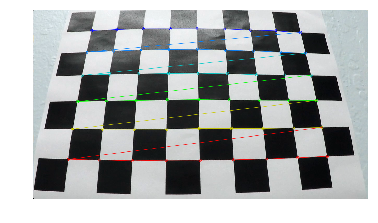

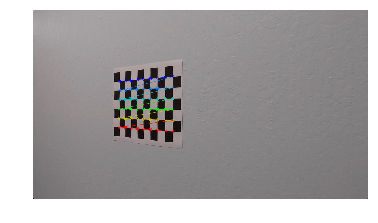

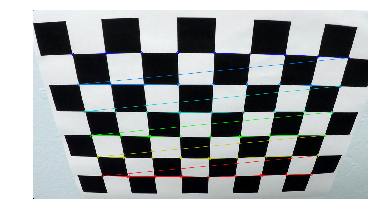

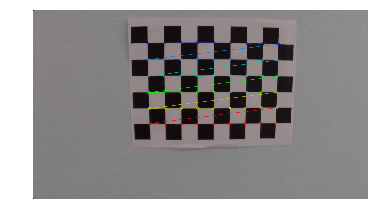

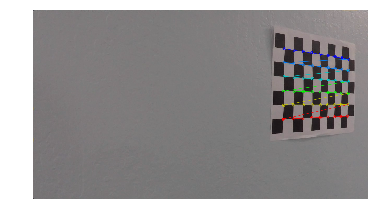

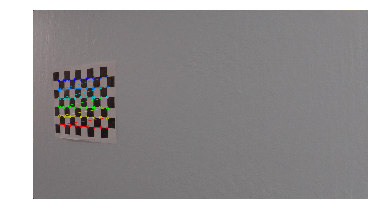

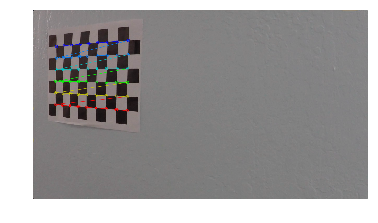

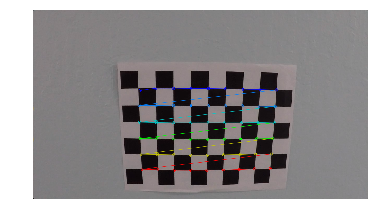

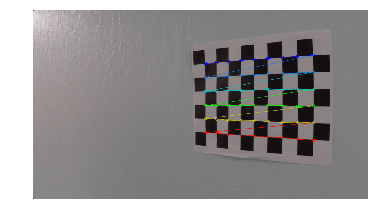

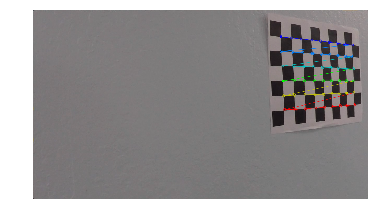

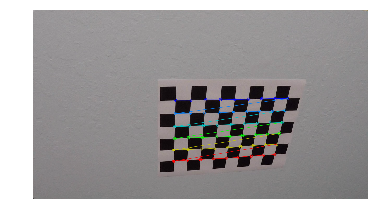

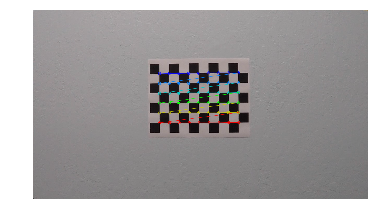

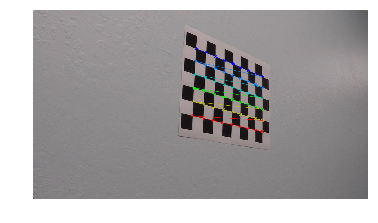

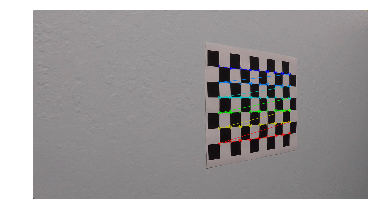

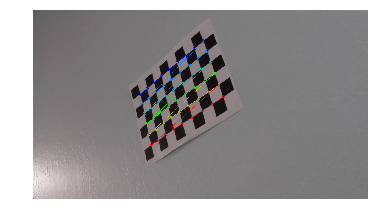

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
#image = mpimg.imread('../camera_cal/calibration1.jpg')
#plt.imshow(image)
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        fig = plt.figure()
        plt.imshow(img)
        plt.axis('off')

## Image correction (Undistortion)

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Gaussian Blur
To work with a smooth image

In [4]:
def gaussian_blur(img, kernel_size):
    #Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

## Birds eyeview

In [5]:
def birds_eye_view(org, src, dst):
    img_size = (org.shape[1], org.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(org, M, img_size)
    return warped, M, Minv

## Gradients

In [6]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

## Combined gradient binary

In [7]:
def get_gradient_binary(gray):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=15, thresh=(20, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=15, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=15, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.1))

    combined_sobel = np.zeros_like(dir_binary)
    combined_sobel[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined_sobel

## Color binaries

In [8]:
def get_color_binaries(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    v_thresh=(170, 255)
    s_thresh=(160, 255)
    #h_thresh=(15, 100)
    #h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #h_binary = np.zeros_like(h_channel)
    #h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return s_binary, v_binary

## ROI for better results

In [9]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Radius of curvature and error estimate

In [10]:
def measure_curvature_and_center_error(left_fit_cr, right_fit_cr, leftx, rightx, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #Identify new coefficients in metres
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_of_image = 640
    center = (lane_center - center_of_image)*xm_per_pix #Convert to meters
    curverad = (left_curverad+right_curverad)/2
    return curverad, center

## Post processing

In [11]:
def add_text(img, cur, err):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % cur, (50, 50), font, 1, (255, 255, 255), 2)

    left_or_right = "left" if err < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(err), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    return img

In [12]:
def inverse_warp(org, warp, Minv, left_fitx, right_fitx, ploty):
    warp = np.zeros_like(warp)
    color_warp = np.dstack((warp, warp, warp))*255 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(org, 1, newwarp, 0.3, 0)
    
    return result


## Test Image pipeline 1

(1, 8, 2)


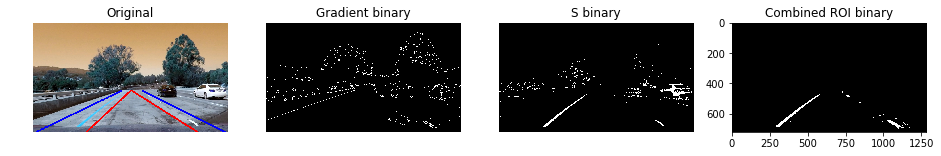

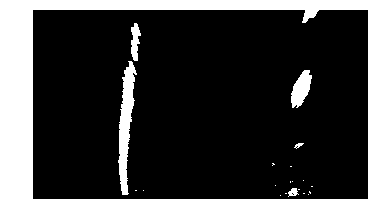

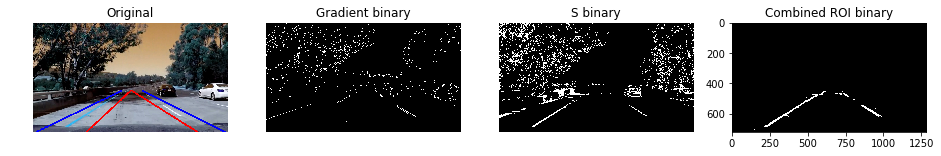

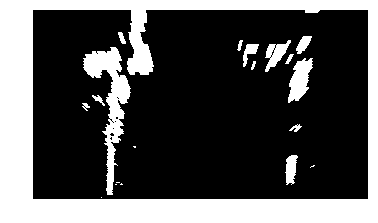

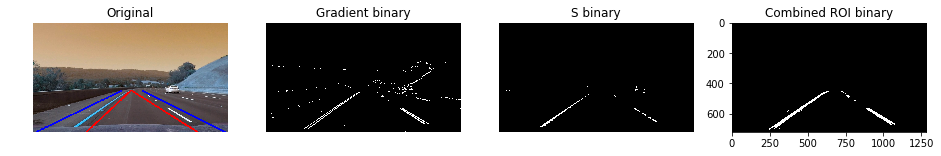

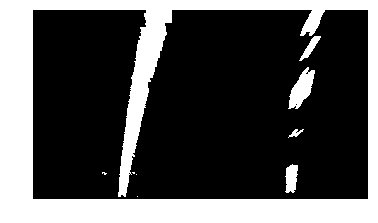

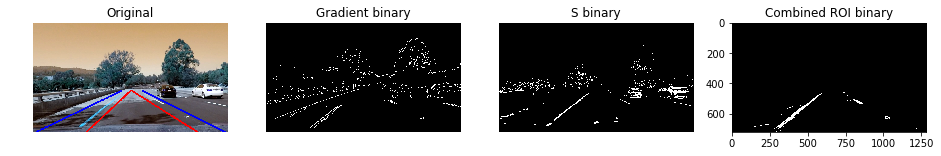

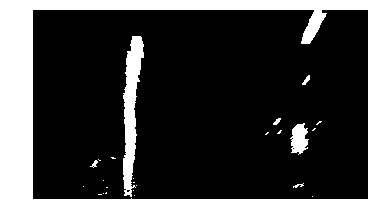

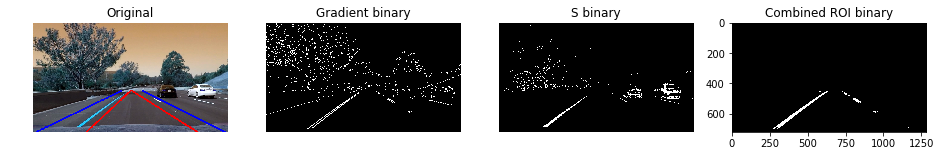

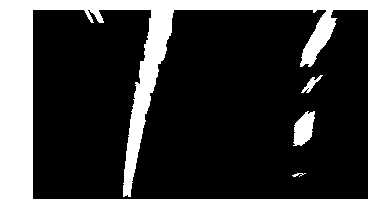

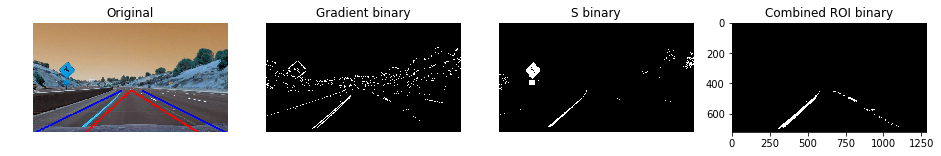

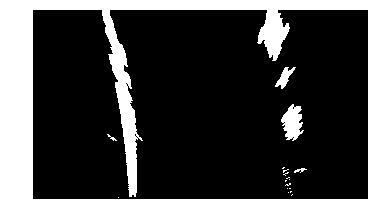

In [13]:
test_images = glob.glob('../test_images/test*.jpg')
source = np.float32([[580, 460], [205, 720], [1110, 720], [705, 460]])
destination = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])
test_dummy = cv2.imread(test_images[0])
imshape = test_dummy.shape
vertices = np.array([[(20,imshape[0]),(580, 450), (720, 450), (imshape[1]-20,imshape[0]), \
                         (350, imshape[0]), (640, 450), (650, 450), (imshape[1]-200, imshape[0])]], dtype=np.int32)
print(vertices.shape)
dilation_kernel = np.ones((3,3),np.uint8)
for idx, fname in enumerate(test_images):
    test_img = cv2.imread(fname)
    undistorted = cal_undistort(test_img, objpoints, imgpoints)
    #warp, M = birds_eye_view(undistorted, source, destination)
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    gradient_binary = get_gradient_binary(gray)
    sbinary, vbinary = get_color_binaries(test_img)
    cv2.line(test_img,tuple(vertices[0][0]),tuple(vertices[0][1]),(0,0,255),10)
    cv2.line(test_img,tuple(vertices[0][2]),tuple(vertices[0][3]),(0,0,255),10)
    cv2.line(test_img,tuple(vertices[0][4]),tuple(vertices[0][5]),(255,0,0),10)
    cv2.line(test_img,tuple(vertices[0][6]),tuple(vertices[0][7]),(255,0,0),10)
    plt.figure(idx, figsize=(16,16))
    plt.subplot(141)
    plt.imshow(test_img)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(gradient_binary, cmap='gray')
    plt.title("Gradient binary")
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(sbinary, cmap='gray')
    plt.title("S binary")
    plt.axis('off')
    combined_binary = np.zeros_like(sbinary)
    combined_binary[(sbinary == 1) | (gradient_binary == 1)] = 1
    
    roi_binary = region_of_interest(combined_binary, vertices)
    dilation = cv2.dilate(roi_binary,dilation_kernel,iterations = 1)
    result_bev, M, Minv = birds_eye_view(dilation, source, destination)
    plt.subplot(144)
    plt.imshow(dilation, cmap='gray')
    plt.title("Combined ROI binary")
    #plt.axis('off')
    plt.figure(idx+10)
    plt.imshow(result_bev, cmap='gray')
    plt.axis('off')

## First frame (finding lane pixels)

In [14]:
def find_lane_pixels(bin_image):
    #print(np.max(bin_image), np.min(bin_image))
    out_img = np.dstack((bin_image, bin_image, bin_image)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(bin_image[bin_image.shape[0]//2:,:], axis=0)#Bottom half
    #print(histogram.shape)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(bin_image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_image.nonzero()
    #print ("nonzero", nonzero)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bin_image.shape[0] - (window+1)*window_height
        win_y_high = bin_image.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 3) 

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

## Second order poly fit

In [15]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

#     ## Visualization ##
#     # Colors in the left and right lane regions
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]
#     plt.figure()
#     plt.imshow(out_img)
#     plt.axis('off')
#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, out_img

## Test image pipeline 2

(720, 1280, 3)
average difference 655.370053088
average difference 653.571507428
average difference 620.148166255
average difference 653.963038226
average difference 636.0014935
average difference 625.39673657


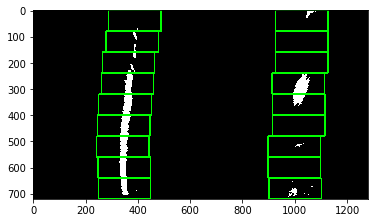

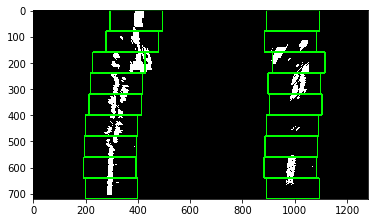

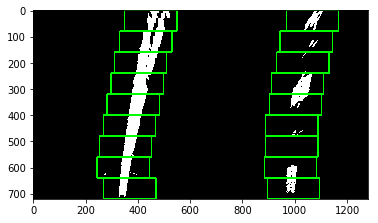

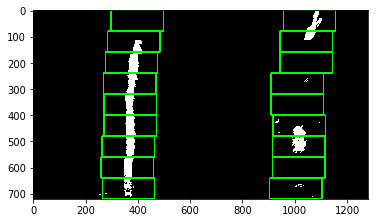

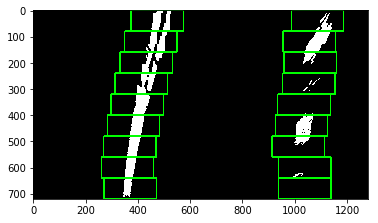

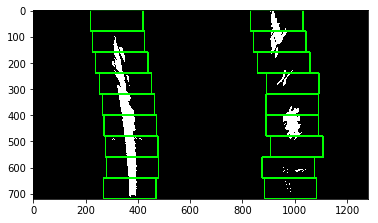

In [16]:
test_images = glob.glob('../test_images/test*.jpg')
source = np.float32([[580, 460], [205, 720], [1110, 720], [705, 460]])
destination = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])
test_dummy = cv2.imread(test_images[0])
imshape = test_dummy.shape
print(imshape)
vertices = np.array([[(100,imshape[0]),(600, 450), (720, 450), (imshape[1]-20,imshape[0]), \
                         (310, imshape[0]), (640, 450), (680, 450), (imshape[1]-200, imshape[0])]], dtype=np.int32)
for idx, fname in enumerate(test_images):
    test_img = cv2.imread(fname)
    undistorted = cal_undistort(test_img, objpoints, imgpoints)
    #warp, M = birds_eye_view(undistorted, source, destination)
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    gradient_binary = get_gradient_binary(gray)
    sbinary, vbinary = get_color_binaries(test_img)
    combined_binary = np.zeros_like(sbinary)
    combined_binary[(sbinary == 1) | (gradient_binary == 1)] = 1
    imshape = test_img.shape

    roi_binary = region_of_interest(combined_binary, vertices)
    #print(vertices)
    result_bev, M, Minv = birds_eye_view(roi_binary, source, destination)
    left_fit, right_fit, out_img = fit_polynomial(result_bev)
    plt.figure()
    plt.imshow(out_img)
    ploty = np.linspace(0, imshape[0]-1, imshape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    #Ay2+By+c
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    avg_diff = np.mean(right_fitx - left_fitx)
    print("average difference", avg_diff)

In [17]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    #Ay2+By+c
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    # Should call only once! when starting or missed a lane
    #left_fit, right_fit, prior_out_img = fit_polynomial(binary_warped) 
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # Fit new polynomials
    
    left_fitx, right_fitx, ploty, fitL, fitR = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    #
    curvature, center = measure_curvature_and_center_error(fitL, fitR, left_fitx, right_fitx, ploty)
    #print ("Radius of curvature and center error: ", curvature, center)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty, fitL, fitR, curvature, center


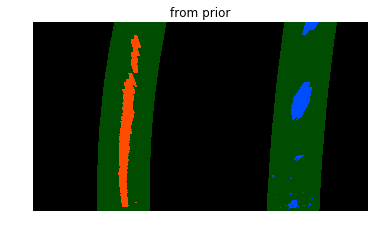

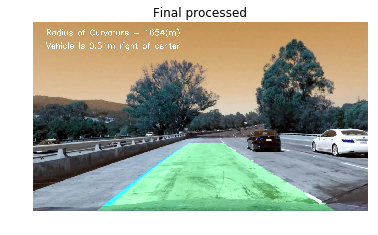

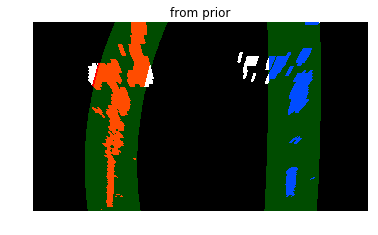

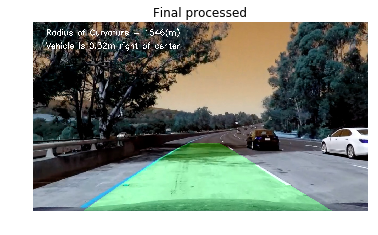

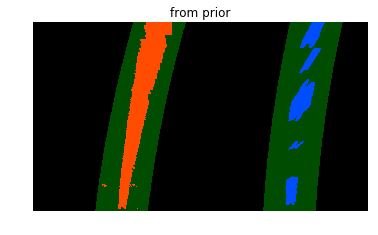

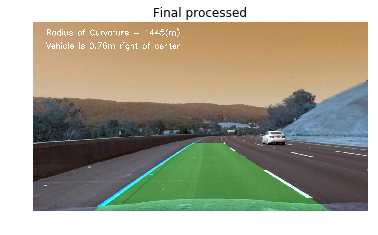

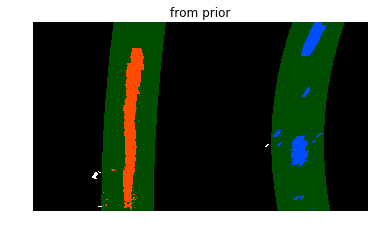

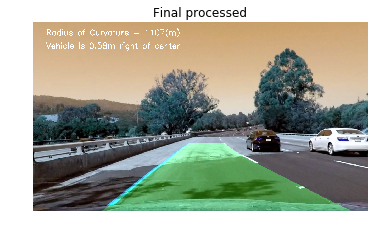

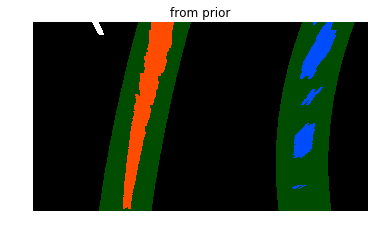

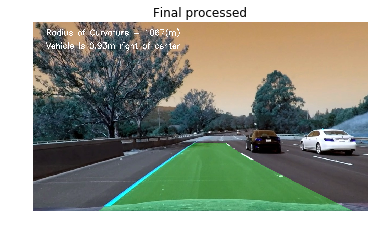

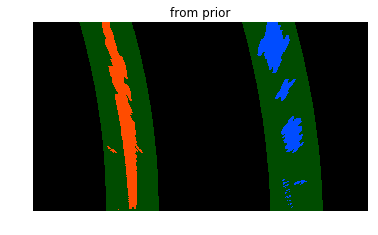

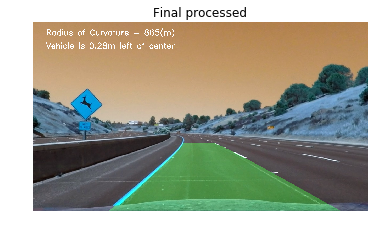

In [18]:
test_images = glob.glob('../test_images/test*.jpg')
source = np.float32([[580, 460], [205, 720], [1110, 720], [705, 460]])
destination = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])
test_dummy = cv2.imread(test_images[0])
imshape = test_dummy.shape
vertices = np.array([[(80,imshape[0]),(580, 450), (720, 450), (imshape[1]-20,imshape[0]), \
                         (330, imshape[0]), (640, 450), (650, 450), (imshape[1]-200, imshape[0])]], dtype=np.int32)
dilation_kernel = np.ones((3,3),np.uint8)
for idx, fname in enumerate(test_images):
    test_img = cv2.imread(fname)
    undistorted = cal_undistort(test_img, objpoints, imgpoints)
    #warp, M = birds_eye_view(undistorted, source, destination)
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    gradient_binary = get_gradient_binary(gray)
    sbinary, vbinary = get_color_binaries(test_img)
    combined_binary = np.zeros_like(sbinary)
    combined_binary[(sbinary == 1) | (gradient_binary == 1)] = 1
    imshape = test_img.shape

    roi_binary = region_of_interest(combined_binary, vertices)
    dilation = cv2.dilate(roi_binary,dilation_kernel,iterations = 1)
    #print(vertices)
    result_bev, M, Minv = birds_eye_view(dilation, source, destination)
    left_fit, right_fit, out_img = fit_polynomial(result_bev)
    result, left_fitx, right_fitx, ploty, fitL, fitR, curvature, center = search_around_poly(result_bev, left_fit, right_fit)
    final_output_no_text = inverse_warp(undistorted, result_bev, Minv, left_fitx, right_fitx, ploty)
    final_output = add_text(final_output_no_text, curvature, center)
    plt.figure()
    plt.imshow(result)
    plt.title("from prior")
    plt.axis('off')
    plt.figure()
    plt.imshow(final_output)
    plt.title("Final processed")
    plt.axis('off')

In [19]:
def pipeline(image):
    global flag, left_fit, right_fit, avg_list
    source = np.float32([[580, 460], [205, 720], [1110, 720], [705, 460]])
    destination = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])
    #test_dummy = cv2.imread(test_images[0])
    imshape = image.shape
    vertices = np.array([[(20,imshape[0]),(580, 450), (720, 450), (imshape[1]-20,imshape[0]), \
                         (350, imshape[0]), (640, 450), (650, 450), (imshape[1]-200, imshape[0])]], dtype=np.int32)
    dilation_kernel = np.ones((3,3),np.uint8)
    undistorted = cal_undistort(image, objpoints, imgpoints)
    #warp, M = birds_eye_view(undistorted, source, destination)
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    gradient_binary = get_gradient_binary(gray)
    sbinary, vbinary = get_color_binaries(test_img)
    combined_binary = np.zeros_like(sbinary)
    combined_binary[(sbinary == 1) | (gradient_binary == 1)] = 1
    imshape = test_img.shape

    roi_binary = region_of_interest(combined_binary, vertices)
    dilation = cv2.dilate(roi_binary,dilation_kernel,iterations = 1)
    #print(vertices)
    result_bev, M, Minv = birds_eye_view(dilation, source, destination)
    #print (flag)
    if flag == True:
        print("I am here!")
        left_fit, right_fit, prior_out_img = fit_polynomial(result_bev)
        flag = False

    result, left_fitx, right_fitx, ploty, left_fit, right_fit, curvature, error = search_around_poly(result_bev, left_fit, right_fit)
    avg_list.append(np.mean(right_fitx - left_fitx))
    if len(left_fit) == 0 or len(right_fit) == 0:
        flag = True

    else:
        avg_diff = np.mean(right_fitx - left_fitx)
        if avg_diff >= 600 and avg_diff <=700: #approx diff in pixels
            flag = False
        else:
            flag = True
    final_output_no_text = inverse_warp(undistorted, result_bev, Minv, left_fitx, right_fitx, ploty)
    final_output = add_text(final_output_no_text, curvature, error)
    return final_output

In [20]:
output = 'test_video.mp4'
clip1 = VideoFileClip("../project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

I am here!
[MoviePy] >>>> Building video test_video.mp4
[MoviePy] Writing video test_video.mp4


  5%|▍         | 62/1261 [00:41<14:54,  1.34it/s]

I am here!


  5%|▍         | 63/1261 [00:41<14:45,  1.35it/s]

I am here!


  5%|▌         | 64/1261 [00:42<14:54,  1.34it/s]

I am here!


  5%|▌         | 65/1261 [00:43<14:46,  1.35it/s]

I am here!


  5%|▌         | 66/1261 [00:44<14:46,  1.35it/s]

I am here!


  5%|▌         | 67/1261 [00:44<14:49,  1.34it/s]

I am here!


  5%|▌         | 68/1261 [00:45<14:41,  1.35it/s]

I am here!


  7%|▋         | 91/1261 [01:02<14:13,  1.37it/s]

I am here!


 10%|▉         | 125/1261 [01:26<13:36,  1.39it/s]

I am here!


 10%|▉         | 126/1261 [01:27<13:32,  1.40it/s]

I am here!


 10%|█         | 130/1261 [01:29<13:06,  1.44it/s]

I am here!


 10%|█         | 131/1261 [01:30<13:15,  1.42it/s]

I am here!


 10%|█         | 132/1261 [01:31<13:28,  1.40it/s]

I am here!


 11%|█         | 133/1261 [01:32<13:41,  1.37it/s]

I am here!


 14%|█▍        | 177/1261 [02:03<13:09,  1.37it/s]

I am here!


 15%|█▍        | 187/1261 [02:10<12:51,  1.39it/s]

I am here!


 15%|█▍        | 188/1261 [02:11<13:34,  1.32it/s]

I am here!


 15%|█▍        | 189/1261 [02:12<13:27,  1.33it/s]

I am here!


 15%|█▌        | 190/1261 [02:12<13:29,  1.32it/s]

I am here!


 15%|█▌        | 191/1261 [02:13<13:28,  1.32it/s]

I am here!


 15%|█▌        | 192/1261 [02:14<13:33,  1.31it/s]

I am here!


 15%|█▌        | 193/1261 [02:15<13:41,  1.30it/s]

I am here!


 15%|█▌        | 194/1261 [02:16<13:36,  1.31it/s]

I am here!


 15%|█▌        | 195/1261 [02:16<13:30,  1.32it/s]

I am here!


 16%|█▌        | 196/1261 [02:17<13:12,  1.34it/s]

I am here!


 18%|█▊        | 227/1261 [02:40<12:45,  1.35it/s]

I am here!


 19%|█▉        | 240/1261 [02:49<12:25,  1.37it/s]

I am here!


 20%|█▉        | 249/1261 [02:55<12:14,  1.38it/s]

I am here!


 20%|█▉        | 250/1261 [02:56<12:26,  1.35it/s]

I am here!


 20%|█▉        | 251/1261 [02:57<12:21,  1.36it/s]

I am here!


 20%|█▉        | 252/1261 [02:58<12:40,  1.33it/s]

I am here!


 21%|██        | 261/1261 [03:04<11:52,  1.40it/s]

I am here!


 25%|██▍       | 314/1261 [03:42<12:07,  1.30it/s]

I am here!


 25%|██▌       | 321/1261 [03:47<11:20,  1.38it/s]

I am here!


 45%|████▍     | 562/1261 [06:45<08:40,  1.34it/s]

I am here!


 45%|████▍     | 563/1261 [06:46<08:50,  1.32it/s]

I am here!


 50%|████▉     | 629/1261 [07:36<08:04,  1.30it/s]

I am here!


 51%|█████     | 638/1261 [07:43<07:44,  1.34it/s]

I am here!


 51%|█████     | 639/1261 [07:43<07:59,  1.30it/s]

I am here!


 51%|█████     | 640/1261 [07:44<07:52,  1.31it/s]

I am here!


 59%|█████▉    | 744/1261 [09:02<05:59,  1.44it/s]

I am here!


 59%|█████▉    | 745/1261 [09:02<06:04,  1.42it/s]

I am here!


 59%|█████▉    | 746/1261 [09:03<06:01,  1.42it/s]

I am here!


 84%|████████▍ | 1062/1261 [12:49<02:28,  1.34it/s]

I am here!


 84%|████████▍ | 1063/1261 [12:50<02:31,  1.31it/s]

I am here!


100%|█████████▉| 1260/1261 [15:12<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.mp4 

CPU times: user 12min 51s, sys: 3.55 s, total: 12min 55s
Wall time: 15min 15s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [31]:
print("avg: ", np.mean(avg_list))
print("Max: ", np.max(avg_list))
print("Min: ", np.min(avg_list))

avg:  392.480280965
Max:  690.229546844
Min:  0.0


In [20]:
output_challenge = 'challenge_video.mp4'
clip1 = VideoFileClip("../challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_challenge, audio=False)

I am here!
[MoviePy] >>>> Building video challenge_video.mp4
[MoviePy] Writing video challenge_video.mp4


  8%|▊         | 40/485 [00:24<04:37,  1.60it/s]

I am here!


  8%|▊         | 41/485 [00:25<04:42,  1.57it/s]

I am here!


  9%|▊         | 42/485 [00:26<04:44,  1.56it/s]

I am here!


  9%|▉         | 44/485 [00:27<05:24,  1.36it/s]

I am here!


  9%|▉         | 45/485 [00:28<05:18,  1.38it/s]

I am here!


  9%|▉         | 46/485 [00:29<05:15,  1.39it/s]

I am here!


 10%|▉         | 47/485 [00:29<05:19,  1.37it/s]

I am here!


 10%|▉         | 48/485 [00:30<05:16,  1.38it/s]

I am here!


 10%|█         | 49/485 [00:31<05:10,  1.40it/s]

I am here!


 10%|█         | 50/485 [00:32<05:05,  1.42it/s]

I am here!


 11%|█         | 51/485 [00:32<05:09,  1.40it/s]

I am here!


 11%|█         | 52/485 [00:33<05:05,  1.42it/s]

I am here!


 11%|█         | 54/485 [00:34<04:58,  1.44it/s]

I am here!


 11%|█▏        | 55/485 [00:35<05:10,  1.39it/s]

I am here!


 12%|█▏        | 56/485 [00:36<05:09,  1.39it/s]

I am here!


 12%|█▏        | 57/485 [00:36<05:04,  1.40it/s]

I am here!


 12%|█▏        | 58/485 [00:37<05:02,  1.41it/s]

I am here!


 13%|█▎        | 64/485 [00:42<05:00,  1.40it/s]

I am here!


 13%|█▎        | 65/485 [00:42<05:06,  1.37it/s]

I am here!


 14%|█▎        | 66/485 [00:43<05:02,  1.38it/s]

I am here!


 14%|█▍        | 67/485 [00:44<04:58,  1.40it/s]

I am here!


 17%|█▋        | 81/485 [00:54<04:33,  1.48it/s]

I am here!


 17%|█▋        | 84/485 [00:56<04:41,  1.43it/s]

I am here!


 19%|█▊        | 90/485 [01:00<04:42,  1.40it/s]

I am here!


 23%|██▎       | 110/485 [01:14<04:20,  1.44it/s]

I am here!


 23%|██▎       | 111/485 [01:15<04:18,  1.45it/s]

I am here!


 23%|██▎       | 113/485 [01:16<04:20,  1.43it/s]

I am here!


 24%|██▎       | 114/485 [01:17<04:25,  1.40it/s]

I am here!


 24%|██▎       | 115/485 [01:18<04:23,  1.41it/s]

I am here!


 24%|██▍       | 116/485 [01:19<04:27,  1.38it/s]

I am here!


 28%|██▊       | 137/485 [01:33<03:58,  1.46it/s]

I am here!


 28%|██▊       | 138/485 [01:34<03:56,  1.47it/s]

I am here!


 29%|██▊       | 139/485 [01:35<03:59,  1.45it/s]

I am here!


 31%|███       | 151/485 [01:43<04:03,  1.37it/s]

I am here!


 31%|███▏      | 152/485 [01:44<04:14,  1.31it/s]

I am here!


 32%|███▏      | 153/485 [01:45<04:08,  1.33it/s]

I am here!


 32%|███▏      | 154/485 [01:45<04:08,  1.33it/s]

I am here!


 32%|███▏      | 155/485 [01:46<04:03,  1.36it/s]

I am here!


 32%|███▏      | 156/485 [01:47<04:04,  1.34it/s]

I am here!


 32%|███▏      | 157/485 [01:48<04:00,  1.36it/s]

I am here!


 33%|███▎      | 158/485 [01:48<04:01,  1.35it/s]

I am here!


 33%|███▎      | 159/485 [01:49<04:02,  1.35it/s]

I am here!


 33%|███▎      | 160/485 [01:50<04:04,  1.33it/s]

I am here!


 33%|███▎      | 161/485 [01:51<04:02,  1.33it/s]

I am here!


 33%|███▎      | 162/485 [01:51<04:00,  1.34it/s]

I am here!


 34%|███▎      | 163/485 [01:52<03:58,  1.35it/s]

I am here!


 34%|███▍      | 164/485 [01:53<03:55,  1.37it/s]

I am here!


 34%|███▍      | 165/485 [01:54<03:51,  1.38it/s]

I am here!


 34%|███▍      | 166/485 [01:54<03:50,  1.38it/s]

I am here!


 34%|███▍      | 167/485 [01:55<03:48,  1.39it/s]

I am here!


 35%|███▍      | 168/485 [01:56<03:47,  1.39it/s]

I am here!


 35%|███▍      | 169/485 [01:56<03:50,  1.37it/s]

I am here!


 35%|███▌      | 170/485 [01:57<03:53,  1.35it/s]

I am here!


 35%|███▌      | 171/485 [01:58<03:53,  1.34it/s]

I am here!


 35%|███▌      | 172/485 [01:59<03:54,  1.33it/s]

I am here!


 36%|███▌      | 173/485 [01:59<03:53,  1.34it/s]

I am here!


 36%|███▌      | 174/485 [02:00<03:52,  1.34it/s]

I am here!


 36%|███▌      | 175/485 [02:01<03:50,  1.34it/s]

I am here!


 36%|███▋      | 176/485 [02:02<03:49,  1.35it/s]

I am here!


 36%|███▋      | 177/485 [02:02<03:49,  1.34it/s]

I am here!


 37%|███▋      | 178/485 [02:03<03:49,  1.34it/s]

I am here!


 37%|███▋      | 179/485 [02:04<03:49,  1.33it/s]

I am here!


 37%|███▋      | 180/485 [02:05<03:48,  1.34it/s]

I am here!


 37%|███▋      | 181/485 [02:05<03:47,  1.33it/s]

I am here!


 39%|███▉      | 190/485 [02:12<03:35,  1.37it/s]

I am here!


 39%|███▉      | 191/485 [02:13<03:35,  1.36it/s]

I am here!


 40%|███▉      | 192/485 [02:13<03:29,  1.40it/s]

I am here!


 40%|███▉      | 193/485 [02:14<03:30,  1.39it/s]

I am here!


 40%|████      | 194/485 [02:15<03:26,  1.41it/s]

I am here!


 40%|████      | 195/485 [02:16<03:28,  1.39it/s]

I am here!


 40%|████      | 196/485 [02:16<03:23,  1.42it/s]

I am here!


 41%|████      | 197/485 [02:17<03:27,  1.39it/s]

I am here!


 41%|████      | 198/485 [02:18<03:24,  1.40it/s]

I am here!


 41%|████      | 199/485 [02:18<03:26,  1.38it/s]

I am here!


 42%|████▏     | 203/485 [02:21<03:25,  1.37it/s]

I am here!


 42%|████▏     | 204/485 [02:22<03:27,  1.35it/s]

I am here!


 42%|████▏     | 205/485 [02:23<03:29,  1.33it/s]

I am here!


 42%|████▏     | 206/485 [02:24<03:25,  1.36it/s]

I am here!


 43%|████▎     | 207/485 [02:24<03:26,  1.34it/s]

I am here!


 43%|████▎     | 208/485 [02:25<03:24,  1.35it/s]

I am here!


 43%|████▎     | 209/485 [02:26<03:26,  1.33it/s]

I am here!


 43%|████▎     | 210/485 [02:27<03:21,  1.36it/s]

I am here!


 45%|████▍     | 217/485 [02:32<03:13,  1.38it/s]

I am here!


 45%|████▍     | 218/485 [02:32<03:11,  1.39it/s]

I am here!


 45%|████▌     | 219/485 [02:33<03:12,  1.38it/s]

I am here!


 45%|████▌     | 220/485 [02:34<03:08,  1.41it/s]

I am here!


 46%|████▌     | 221/485 [02:34<03:08,  1.40it/s]

I am here!


 46%|████▌     | 222/485 [02:35<03:03,  1.43it/s]

I am here!


 46%|████▌     | 223/485 [02:36<03:07,  1.40it/s]

I am here!


 46%|████▌     | 224/485 [02:36<03:03,  1.42it/s]

I am here!


 46%|████▋     | 225/485 [02:37<03:04,  1.41it/s]

I am here!


 47%|████▋     | 229/485 [02:40<03:03,  1.39it/s]

I am here!


 47%|████▋     | 230/485 [02:41<03:01,  1.41it/s]

I am here!


 48%|████▊     | 231/485 [02:41<03:03,  1.39it/s]

I am here!


 48%|████▊     | 232/485 [02:42<03:00,  1.40it/s]

I am here!


 48%|████▊     | 233/485 [02:43<03:01,  1.39it/s]

I am here!


 48%|████▊     | 234/485 [02:44<03:03,  1.37it/s]

I am here!


 48%|████▊     | 235/485 [02:44<03:03,  1.36it/s]

I am here!


 49%|████▊     | 236/485 [02:45<03:04,  1.35it/s]

I am here!


 49%|████▉     | 237/485 [02:46<03:00,  1.38it/s]

I am here!


 49%|████▉     | 238/485 [02:47<03:11,  1.29it/s]

I am here!


 50%|████▉     | 242/485 [02:50<03:04,  1.32it/s]

I am here!


 50%|█████     | 243/485 [02:51<03:04,  1.31it/s]

I am here!


 50%|█████     | 244/485 [02:51<02:59,  1.35it/s]

I am here!


 51%|█████     | 245/485 [02:52<03:01,  1.32it/s]

I am here!


 51%|█████     | 246/485 [02:53<02:57,  1.35it/s]

I am here!


 51%|█████     | 247/485 [02:54<02:57,  1.34it/s]

I am here!


 51%|█████     | 248/485 [02:54<02:51,  1.38it/s]

I am here!


 51%|█████▏    | 249/485 [02:55<02:48,  1.40it/s]

I am here!


 52%|█████▏    | 250/485 [02:56<02:50,  1.38it/s]

I am here!


 52%|█████▏    | 251/485 [02:56<02:47,  1.40it/s]

I am here!


 52%|█████▏    | 252/485 [02:57<02:43,  1.42it/s]

I am here!


 53%|█████▎    | 259/485 [03:02<02:41,  1.40it/s]

I am here!


 54%|█████▎    | 260/485 [03:03<02:41,  1.40it/s]

I am here!


 54%|█████▍    | 261/485 [03:04<02:44,  1.36it/s]

I am here!


 54%|█████▍    | 262/485 [03:04<02:42,  1.37it/s]

I am here!


 56%|█████▋    | 273/485 [03:12<02:32,  1.39it/s]

I am here!


 56%|█████▋    | 274/485 [03:13<02:34,  1.37it/s]

I am here!


 57%|█████▋    | 275/485 [03:14<02:32,  1.38it/s]

I am here!


 57%|█████▋    | 276/485 [03:14<02:32,  1.37it/s]

I am here!


 57%|█████▋    | 277/485 [03:15<02:30,  1.38it/s]

I am here!


 57%|█████▋    | 278/485 [03:16<02:27,  1.40it/s]

I am here!


 58%|█████▊    | 279/485 [03:17<02:29,  1.38it/s]

I am here!


 58%|█████▊    | 280/485 [03:17<02:26,  1.40it/s]

I am here!


 58%|█████▊    | 281/485 [03:18<02:23,  1.42it/s]

I am here!


 58%|█████▊    | 283/485 [03:19<02:24,  1.40it/s]

I am here!


 59%|█████▊    | 284/485 [03:20<02:26,  1.37it/s]

I am here!


 59%|█████▉    | 285/485 [03:21<02:24,  1.38it/s]

I am here!


 59%|█████▉    | 286/485 [03:22<02:23,  1.39it/s]

I am here!


 59%|█████▉    | 287/485 [03:22<02:25,  1.36it/s]

I am here!


 59%|█████▉    | 288/485 [03:23<02:23,  1.37it/s]

I am here!


 60%|█████▉    | 289/485 [03:24<02:21,  1.38it/s]

I am here!


 60%|█████▉    | 290/485 [03:25<02:23,  1.36it/s]

I am here!


 60%|██████    | 291/485 [03:25<02:21,  1.37it/s]

I am here!


 60%|██████    | 292/485 [03:26<02:19,  1.38it/s]

I am here!


 60%|██████    | 293/485 [03:27<02:23,  1.34it/s]

I am here!


 61%|██████    | 294/485 [03:27<02:20,  1.36it/s]

I am here!


 61%|██████    | 295/485 [03:28<02:18,  1.37it/s]

I am here!


 62%|██████▏   | 299/485 [03:31<02:12,  1.40it/s]

I am here!


 62%|██████▏   | 301/485 [03:32<02:12,  1.39it/s]

I am here!


 62%|██████▏   | 302/485 [03:33<02:11,  1.40it/s]

I am here!


 62%|██████▏   | 303/485 [03:34<02:13,  1.37it/s]

I am here!


 63%|██████▎   | 304/485 [03:35<02:10,  1.39it/s]

I am here!


 63%|██████▎   | 305/485 [03:35<02:07,  1.41it/s]

I am here!


 63%|██████▎   | 306/485 [03:36<02:08,  1.40it/s]

I am here!


 63%|██████▎   | 307/485 [03:37<02:05,  1.42it/s]

I am here!


 64%|██████▍   | 312/485 [03:40<02:00,  1.44it/s]

I am here!


 65%|██████▍   | 313/485 [03:41<02:02,  1.40it/s]

I am here!


 65%|██████▍   | 314/485 [03:42<02:01,  1.40it/s]

I am here!


 65%|██████▍   | 315/485 [03:42<02:03,  1.38it/s]

I am here!


 65%|██████▌   | 316/485 [03:43<02:01,  1.39it/s]

I am here!


 65%|██████▌   | 317/485 [03:44<02:00,  1.40it/s]

I am here!


 66%|██████▌   | 318/485 [03:45<02:01,  1.37it/s]

I am here!


 66%|██████▌   | 319/485 [03:45<01:59,  1.39it/s]

I am here!


 66%|██████▌   | 320/485 [03:46<02:00,  1.37it/s]

I am here!


 66%|██████▌   | 321/485 [03:47<01:58,  1.38it/s]

I am here!


 66%|██████▋   | 322/485 [03:47<01:58,  1.37it/s]

I am here!


 67%|██████▋   | 323/485 [03:48<01:56,  1.39it/s]

I am here!


 67%|██████▋   | 324/485 [03:49<01:58,  1.36it/s]

I am here!


 67%|██████▋   | 325/485 [03:50<01:55,  1.39it/s]

I am here!


 67%|██████▋   | 326/485 [03:50<01:55,  1.37it/s]

I am here!


 67%|██████▋   | 327/485 [03:51<01:53,  1.39it/s]

I am here!


 68%|██████▊   | 328/485 [03:52<01:54,  1.37it/s]

I am here!


 68%|██████▊   | 329/485 [03:53<01:53,  1.38it/s]

I am here!


 68%|██████▊   | 330/485 [03:53<01:53,  1.36it/s]

I am here!


 68%|██████▊   | 331/485 [03:54<01:51,  1.38it/s]

I am here!


 68%|██████▊   | 332/485 [03:55<01:52,  1.36it/s]

I am here!


 69%|██████▊   | 333/485 [03:55<01:49,  1.39it/s]

I am here!


 69%|██████▉   | 334/485 [03:56<01:48,  1.39it/s]

I am here!


 69%|██████▉   | 335/485 [03:57<01:46,  1.41it/s]

I am here!


 69%|██████▉   | 336/485 [03:58<01:46,  1.39it/s]

I am here!


 69%|██████▉   | 337/485 [03:58<01:44,  1.42it/s]

I am here!


 70%|██████▉   | 338/485 [03:59<01:43,  1.42it/s]

I am here!


 70%|██████▉   | 339/485 [04:00<01:43,  1.41it/s]

I am here!


 70%|███████   | 340/485 [04:00<01:42,  1.42it/s]

I am here!


 70%|███████   | 341/485 [04:01<01:43,  1.40it/s]

I am here!


 71%|███████   | 342/485 [04:02<01:41,  1.40it/s]

I am here!


 71%|███████   | 343/485 [04:03<01:43,  1.37it/s]

I am here!


 71%|███████   | 344/485 [04:03<01:41,  1.39it/s]

I am here!


 71%|███████   | 345/485 [04:04<01:42,  1.36it/s]

I am here!


 71%|███████▏  | 346/485 [04:05<01:40,  1.38it/s]

I am here!


 72%|███████▏  | 347/485 [04:06<01:41,  1.36it/s]

I am here!


 72%|███████▏  | 348/485 [04:06<01:38,  1.39it/s]

I am here!


 72%|███████▏  | 349/485 [04:07<01:39,  1.37it/s]

I am here!


 72%|███████▏  | 350/485 [04:08<01:37,  1.39it/s]

I am here!


 72%|███████▏  | 351/485 [04:08<01:37,  1.38it/s]

I am here!


 73%|███████▎  | 352/485 [04:09<01:35,  1.40it/s]

I am here!


 73%|███████▎  | 353/485 [04:10<01:35,  1.38it/s]

I am here!


 73%|███████▎  | 354/485 [04:11<01:32,  1.41it/s]

I am here!


 73%|███████▎  | 355/485 [04:11<01:33,  1.39it/s]

I am here!


 73%|███████▎  | 356/485 [04:12<01:32,  1.39it/s]

I am here!


 74%|███████▎  | 357/485 [04:13<01:33,  1.37it/s]

I am here!


 74%|███████▍  | 358/485 [04:13<01:31,  1.39it/s]

I am here!


 74%|███████▍  | 359/485 [04:14<01:32,  1.36it/s]

I am here!


 74%|███████▍  | 360/485 [04:15<01:30,  1.37it/s]

I am here!


 74%|███████▍  | 361/485 [04:16<01:31,  1.35it/s]

I am here!


 75%|███████▍  | 362/485 [04:16<01:28,  1.39it/s]

I am here!


 75%|███████▍  | 363/485 [04:17<01:27,  1.40it/s]

I am here!


 75%|███████▌  | 364/485 [04:18<01:24,  1.43it/s]

I am here!


 75%|███████▌  | 365/485 [04:18<01:24,  1.41it/s]

I am here!


 75%|███████▌  | 366/485 [04:19<01:22,  1.43it/s]

I am here!


 76%|███████▌  | 367/485 [04:20<01:23,  1.42it/s]

I am here!


 76%|███████▌  | 368/485 [04:21<01:21,  1.43it/s]

I am here!


 76%|███████▌  | 369/485 [04:21<01:22,  1.40it/s]

I am here!


 76%|███████▋  | 370/485 [04:22<01:21,  1.40it/s]

I am here!


 76%|███████▋  | 371/485 [04:23<01:22,  1.38it/s]

I am here!


 77%|███████▋  | 372/485 [04:23<01:20,  1.40it/s]

I am here!


 77%|███████▋  | 373/485 [04:24<01:22,  1.36it/s]

I am here!


 77%|███████▋  | 374/485 [04:25<01:21,  1.37it/s]

I am here!


 77%|███████▋  | 375/485 [04:26<01:21,  1.35it/s]

I am here!


 78%|███████▊  | 376/485 [04:26<01:19,  1.37it/s]

I am here!


 78%|███████▊  | 377/485 [04:27<01:20,  1.35it/s]

I am here!


 78%|███████▊  | 378/485 [04:28<01:18,  1.37it/s]

I am here!


 78%|███████▊  | 379/485 [04:29<01:18,  1.34it/s]

I am here!


 78%|███████▊  | 380/485 [04:29<01:17,  1.36it/s]

I am here!


 79%|███████▊  | 381/485 [04:30<01:17,  1.35it/s]

I am here!


 79%|███████▉  | 382/485 [04:31<01:15,  1.37it/s]

I am here!


 79%|███████▉  | 383/485 [04:32<01:14,  1.36it/s]

I am here!


 79%|███████▉  | 384/485 [04:32<01:13,  1.37it/s]

I am here!


 79%|███████▉  | 385/485 [04:33<01:14,  1.35it/s]

I am here!


 80%|███████▉  | 386/485 [04:34<01:13,  1.35it/s]

I am here!


 80%|███████▉  | 387/485 [04:34<01:11,  1.37it/s]

I am here!


 80%|████████  | 388/485 [04:35<01:11,  1.35it/s]

I am here!


 80%|████████  | 389/485 [04:36<01:10,  1.37it/s]

I am here!


 80%|████████  | 390/485 [04:37<01:10,  1.36it/s]

I am here!


 81%|████████  | 392/485 [04:38<01:06,  1.39it/s]

I am here!


 81%|████████  | 393/485 [04:39<01:05,  1.41it/s]

I am here!


 81%|████████  | 394/485 [04:39<01:04,  1.42it/s]

I am here!


 81%|████████▏ | 395/485 [04:40<01:04,  1.40it/s]

I am here!


 82%|████████▏ | 396/485 [04:41<01:02,  1.42it/s]

I am here!


 82%|████████▏ | 397/485 [04:42<01:02,  1.41it/s]

I am here!


 82%|████████▏ | 398/485 [04:42<01:03,  1.38it/s]

I am here!


 82%|████████▏ | 399/485 [04:43<01:01,  1.39it/s]

I am here!


 82%|████████▏ | 400/485 [04:44<01:01,  1.39it/s]

I am here!


 83%|████████▎ | 401/485 [04:45<01:01,  1.36it/s]

I am here!


 83%|████████▎ | 402/485 [04:45<01:00,  1.37it/s]

I am here!


 83%|████████▎ | 403/485 [04:46<01:00,  1.35it/s]

I am here!


 83%|████████▎ | 404/485 [04:47<00:59,  1.37it/s]

I am here!


 84%|████████▎ | 406/485 [04:49<01:07,  1.17it/s]

I am here!


 84%|████████▍ | 407/485 [04:50<01:03,  1.23it/s]

I am here!


 84%|████████▍ | 408/485 [04:50<01:01,  1.24it/s]

I am here!


 84%|████████▍ | 409/485 [04:51<00:58,  1.29it/s]

I am here!


 85%|████████▍ | 410/485 [04:52<00:57,  1.31it/s]

I am here!


 85%|████████▍ | 411/485 [04:52<00:55,  1.34it/s]

I am here!


 85%|████████▍ | 412/485 [04:53<00:54,  1.33it/s]

I am here!


 85%|████████▌ | 413/485 [04:54<00:53,  1.34it/s]

I am here!


 85%|████████▌ | 414/485 [04:55<00:52,  1.35it/s]

I am here!


 86%|████████▌ | 415/485 [04:55<00:52,  1.32it/s]

I am here!


 86%|████████▌ | 416/485 [04:56<00:51,  1.34it/s]

I am here!


 86%|████████▌ | 417/485 [04:57<00:51,  1.33it/s]

I am here!


 86%|████████▌ | 418/485 [04:58<00:49,  1.37it/s]

I am here!


 86%|████████▋ | 419/485 [04:58<00:47,  1.39it/s]

I am here!


 87%|████████▋ | 420/485 [04:59<00:47,  1.38it/s]

I am here!


 87%|████████▋ | 421/485 [05:00<00:45,  1.40it/s]

I am here!


 87%|████████▋ | 422/485 [05:00<00:45,  1.39it/s]

I am here!


 87%|████████▋ | 423/485 [05:01<00:43,  1.42it/s]

I am here!


 88%|████████▊ | 426/485 [05:03<00:42,  1.40it/s]

I am here!


 88%|████████▊ | 427/485 [05:04<00:42,  1.37it/s]

I am here!


 88%|████████▊ | 428/485 [05:05<00:41,  1.38it/s]

I am here!


 88%|████████▊ | 429/485 [05:06<00:40,  1.39it/s]

I am here!


 89%|████████▊ | 430/485 [05:06<00:40,  1.36it/s]

I am here!


 89%|████████▉ | 431/485 [05:07<00:39,  1.36it/s]

I am here!


 89%|████████▉ | 432/485 [05:08<00:38,  1.37it/s]

I am here!


 89%|████████▉ | 433/485 [05:08<00:38,  1.35it/s]

I am here!


 92%|█████████▏| 447/485 [05:18<00:26,  1.41it/s]

I am here!


 92%|█████████▏| 448/485 [05:19<00:25,  1.43it/s]

I am here!


 93%|█████████▎| 449/485 [05:20<00:24,  1.44it/s]

I am here!


 93%|█████████▎| 450/485 [05:20<00:24,  1.41it/s]

I am here!


100%|██████████| 485/485 [05:45<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video.mp4 

CPU times: user 4min 55s, sys: 1.52 s, total: 4min 56s
Wall time: 5min 48s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_challenge))